✅ Weather data loaded into /Users/arijitguchhait/Desktop/mydb/Database/weather.db (next 7 days only)


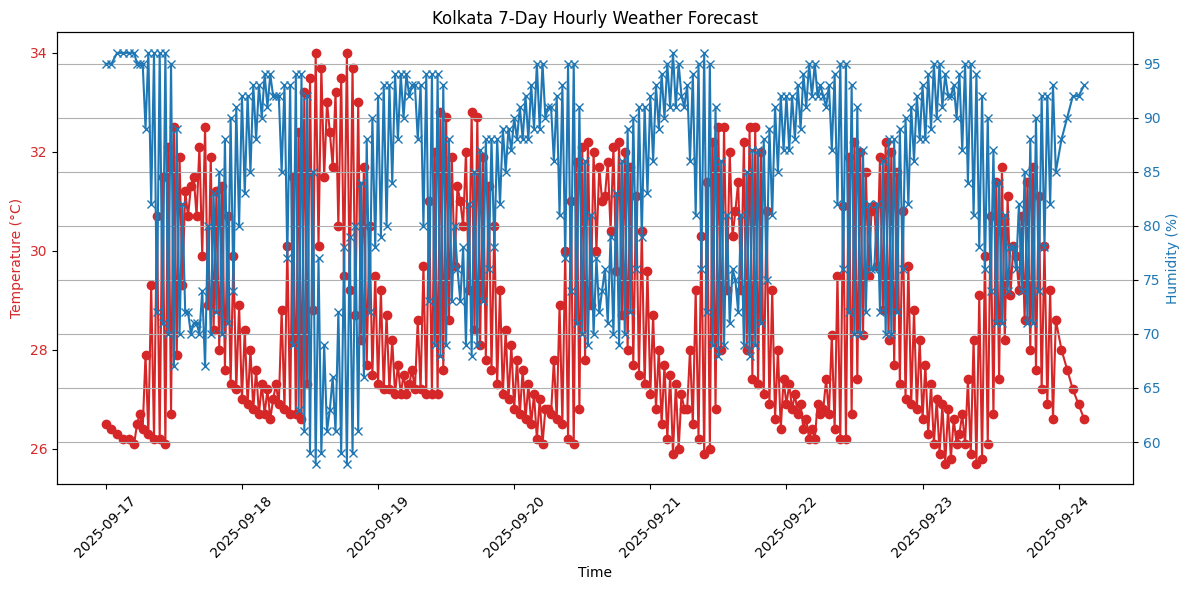

In [80]:
#!/usr/bin/env python3

import requests
import pandas as pd
import sqlite3
import os
from datetime import timedelta
import matplotlib.pyplot as plt

# -----------------------
# Config
# -----------------------
DB_DIR = "/Users/arijitguchhait/Desktop/mydb/Database"
DB_NAME = "weather.db"
TABLE_NAME = "kolkata_weather"
LATITUDE = 22.5726
LONGITUDE = 88.3639
TIMEZONE = "Asia/Kolkata"
db_path = os.path.join(DB_DIR, DB_NAME)

# -----------------------
# 1️⃣ Extract
# -----------------------
def extract_weather(latitude=LATITUDE, longitude=LONGITUDE):
    url = (
        f"https://api.open-meteo.com/v1/forecast"
        f"?latitude={latitude}&longitude={longitude}"
        f"&hourly=temperature_2m,relative_humidity_2m"
        f"&timezone={TIMEZONE}"
    )
    resp = requests.get(url)
    resp.raise_for_status()
    return resp.json()['hourly']

# -----------------------
# 2️⃣ Transform
# -----------------------
def transform_weather(hourly_data):
    df = pd.DataFrame({
        'time': hourly_data['time'],
        'temperature_c': hourly_data['temperature_2m'],
        'humidity': hourly_data['relative_humidity_2m']
    })

    # Parse ISO8601 strings, which are already in UTC
    df['time'] = pd.to_datetime(df['time'], utc=True)

    # Convert to Kolkata timezone
    df['time'] = df['time'].dt.tz_convert(TIMEZONE)

    # Add ETL timestamp
    df['extracted_at'] = pd.Timestamp.now(tz=TIMEZONE)

    # Use a timezone-aware 'now' for comparison
    now = pd.Timestamp.now(tz=TIMEZONE)

    # Keep only next 7 days
    df = df[df['time'] <= now + timedelta(days=7)].copy()

    return df

# -----------------------
# 3️⃣ Load
# -----------------------
def load_to_sqlite(df):
    os.makedirs(DB_DIR, exist_ok=True)
    
    with sqlite3.connect(db_path) as conn:
        cursor = conn.cursor()
        cursor.execute(f"""
            CREATE TABLE IF NOT EXISTS {TABLE_NAME} (
                time TEXT PRIMARY KEY,
                temperature_c REAL,
                humidity REAL,
                extracted_at TEXT
            )
        """)

        # Insert or replace rows
        for _, row in df.iterrows():
            cursor.execute(f"""
                INSERT OR REPLACE INTO {TABLE_NAME} (time, temperature_c, humidity, extracted_at)
                VALUES (?, ?, ?, ?)
            """, (
                row['time'].isoformat(),
                row['temperature_c'],
                row['humidity'],
                row['extracted_at'].isoformat()
            ))
        conn.commit()

    print(f"✅ Weather data loaded into {db_path} (next 7 days only)")

# -----------------------
# 4️⃣ Plot
# -----------------------
def plot_weather():
    with sqlite3.connect(db_path) as conn:
        df = pd.read_sql(f"SELECT * FROM {TABLE_NAME} ORDER BY time ASC", conn)
    # errors='coerce' will replace any un-parsable values with NaT
    df['time'] = pd.to_datetime(df['time'], format='%Y-%m-%dT%H:%M:%S%z', errors='coerce')

    # Drop any rows where time could not be parsed
    df.dropna(subset=['time'], inplace=True)

    # Make naive datetime for matplotlib plotting
    # This step is needed because Matplotlib can have issues plotting tz-aware objects
    df['time_plot'] = df['time'].dt.tz_localize(None)

    # Plot temperature
    fig, ax1 = plt.subplots(figsize=(12,6))
    ax1.plot(df['time_plot'], df['temperature_c'], color='tab:red', marker='o', label="Temperature (°C)")
    ax1.set_xlabel("Time")
    ax1.set_ylabel("Temperature (°C)", color="tab:red")
    ax1.tick_params(axis="y", labelcolor="tab:red")
    plt.xticks(rotation=45)

    # Plot humidity
    ax2 = ax1.twinx()
    ax2.plot(df['time_plot'], df['humidity'], color='tab:blue', marker='x', label="Humidity (%)")
    ax2.set_ylabel("Humidity (%)", color="tab:blue")
    ax2.tick_params(axis="y", labelcolor="tab:blue")

    plt.title("Kolkata 7-Day Hourly Weather Forecast")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# -----------------------
# 5️⃣ Run ETL + Plot
# -----------------------
def run_etl():
    hourly_data = extract_weather()
    df = transform_weather(hourly_data)
    load_to_sqlite(df)
    plot_weather()

# -----------------------
if __name__ == "__main__":
    run_etl()


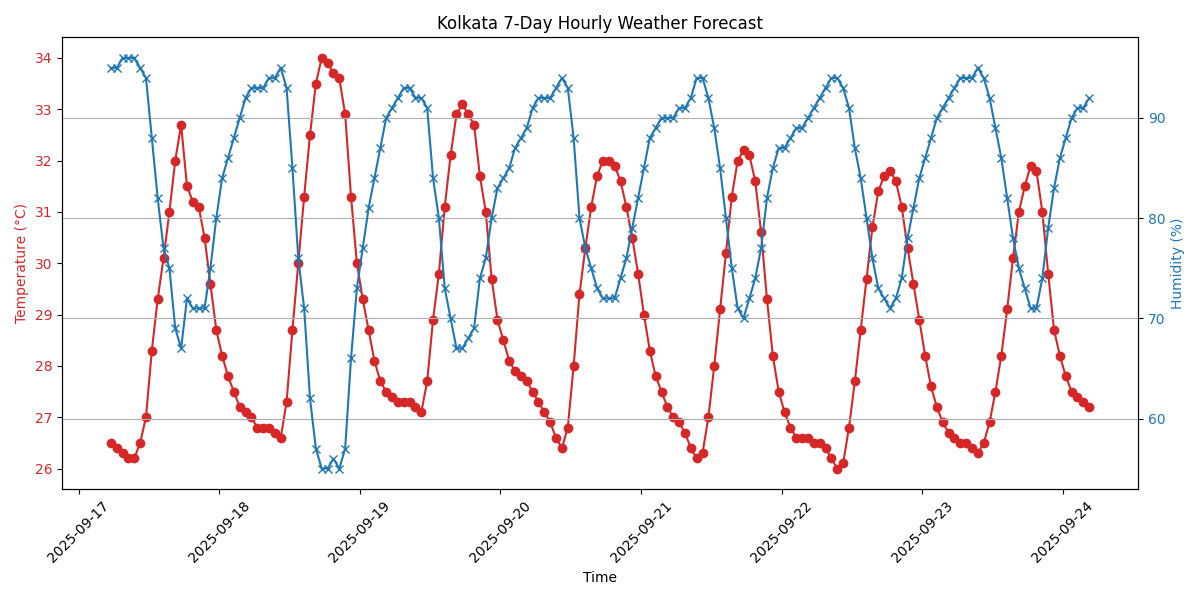

In [85]:
# parse ISO times for nicer display
from IPython.display import Image, display
display(Image("/Users/arijitguchhait/Desktop/mydb/ETL/kolkata_weather_plot.png"))
